# (Ford Gobike Data Exploration)
## by (Abdelrahman Moustafa)

## Preliminary Wrangling

> This data set includes information about individual rides made
in a bike-sharing system covering the greater San Francisco. <br> Because of the size of the dataset, this research only focuses on the data in 2019.

In [200]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
from datetime import datetime
%matplotlib inline

In [201]:
# Load dataset into dataframe
df = pd.read_csv('201902-fordgobike-tripdata.csv')

# Copy the dataset to work on it
df_copy = df.copy()
df_copy.sample(3)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip
154675,871,2019-02-06 09:23:30.4200,2019-02-06 09:38:01.6230,125.0,20th St at Bryant St,37.759200,-122.409851,3.0,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,1900,Subscriber,1994.0,Male,No
47740,500,2019-02-22 08:31:21.3310,2019-02-22 08:39:41.8120,140.0,Cesar Chavez St at Dolores St,37.747858,-122.424986,123.0,Folsom St at 19th St,37.760594,-122.414817,6593,Subscriber,1984.0,Male,No
176680,285,2019-02-02 10:49:54.8140,2019-02-02 10:54:40.6020,133.0,Valencia St at 22nd St,37.755213,-122.420975,107.0,17th St at Dolores St,37.763015,-122.426497,5534,Subscriber,1994.0,Male,No


In [202]:
print('Shape of dataframe is: ', df_copy.shape[0], 'rows', 
      df_copy.shape[1], 'columns', '\n')
print('Duplicated of values is: ', df_copy.duplicated().sum(), '\n')
print(df_copy.isnull().sum(), '\n\n')
print(df_copy.info(), '\n\n')
round(df_copy.describe()['duration_sec'], 2)

Shape of dataframe is:  183412 rows 16 columns 

Duplicated of values is:  0 

duration_sec                  0
start_time                    0
end_time                      0
start_station_id            197
start_station_name          197
start_station_latitude        0
start_station_longitude       0
end_station_id              197
end_station_name            197
end_station_latitude          0
end_station_longitude         0
bike_id                       0
user_type                     0
member_birth_year          8265
member_gender              8265
bike_share_for_all_trip       0
dtype: int64 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 183412 entries, 0 to 183411
Data columns (total 16 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             183412 non-null  int64  
 1   start_time               183412 non-null  object 
 2   end_time                 183412 non-null  object 
 3   st

count    183412.00
mean        726.08
std        1794.39
min          61.00
25%         325.00
50%         514.00
75%         796.00
max       85444.00
Name: duration_sec, dtype: float64

##### Data Cleaning
- There's some columns need to change their data types
- Some values ara missing 

In [203]:
# Drop missing values
df_copy.dropna(inplace=True)

# convert to datetime
df_copy.start_time, df_copy.end_time = pd.to_datetime(
    df_copy.start_time, errors='coerce'), pd.to_datetime(
    df_copy.end_time, errors='coerce')

# convert float values to int
df_copy = df_copy.astype({'start_station_id':'int','member_birth_year':'int'})

# convert to conditional column true and false
df_copy.bike_share_for_all_trip = (df_copy.bike_share_for_all_trip == 'Yes')

# convert duration from sec to min
df_copy['duration_min'] = df_copy['duration_sec'] / 60

# making new columns to know the weekday of trips and start hour of trip
df_copy['start_weekday_num'] = df_copy['start_time'].apply(lambda time: 
                                                           time.dayofweek)
d = {0:'Mon',1:'Tue',2:'Wed',3:'Thu',4:'Fri',5:'Sat',6:'Sun'}
df_copy['start_weekday'] = df_copy['start_weekday_num'].map(d)
df_copy.drop('start_weekday_num', axis=1, inplace=True)

df_copy['start_hour'] = df_copy.start_time.dt.hour

In [204]:
df_copy.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174952 entries, 0 to 183411
Data columns (total 19 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   duration_sec             174952 non-null  int64         
 1   start_time               174952 non-null  datetime64[ns]
 2   end_time                 174952 non-null  datetime64[ns]
 3   start_station_id         174952 non-null  int32         
 4   start_station_name       174952 non-null  object        
 5   start_station_latitude   174952 non-null  float64       
 6   start_station_longitude  174952 non-null  float64       
 7   end_station_id           174952 non-null  float64       
 8   end_station_name         174952 non-null  object        
 9   end_station_latitude     174952 non-null  float64       
 10  end_station_longitude    174952 non-null  float64       
 11  bike_id                  174952 non-null  int64         
 12  user_type       

### What is the structure of your dataset?

> 174952 observation, 19 columns with 11 numerical columns and 2 datetime, 5 object, 1 bolean

### What is/are the main feature(s) of interest in your dataset?

> I'm most interested in figuring out how trip duration is dependent on other features such as: age, start station, end station, user type, and gender from the dataset.


### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> I expect that trip duration will have the strongest effect on each the start stations and end stations becouse the crowded places should receive more rides. I also think that user_type, age, and gender will have effects on trip duration.

## Univariate Exploration
> I'll start by looking at the duration_min as the main variable of interest. To determine the average bike trips as a unit of time.

#### Distribution Of Trip Duration

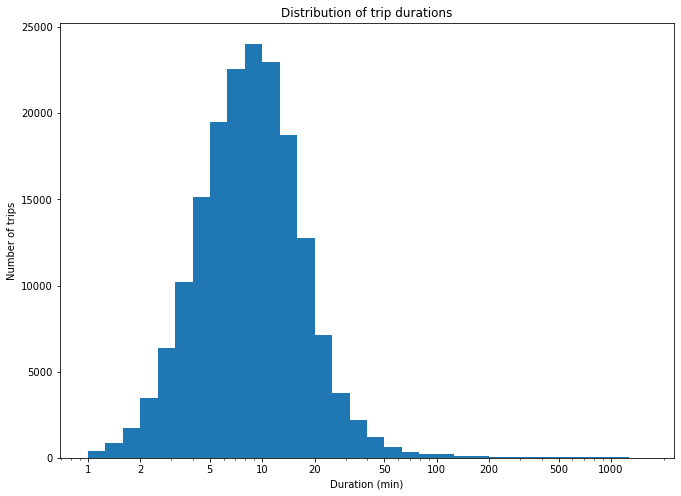

In [205]:
# Logarthmic scale transformation on a histogram
# There's a long tail in the distribution, so let's put it 
# on a log scale instead

log_binsize = 0.1
log_bins = 10 ** np.arange(0, np.log10(df_copy['duration_min'].max())
                           + log_binsize, log_binsize)

plt.figure(figsize=[11, 8])
plt.hist(data = df_copy, x = 'duration_min', bins = log_bins)
plt.title('Distribution of trip durations')
plt.xlabel('Duration (min)')
plt.ylabel('Number of trips')
plt.xscale('log')
tick_locs = [1, 2, 5, 10, 20, 50, 100, 200, 500, 1000]
plt.xticks(tick_locs, tick_locs);

> Duration has a long tailed distribution. Most of the bike trips lasts between 8 and 15 minutes. There are a lot of bike trips less than 3 minutes and over 40 minutes

In [206]:
round(df_copy.duration_min.describe(), 2)

count    174952.00
mean         11.73
std          27.37
min           1.02
25%           5.38
50%           8.50
75%          13.15
max        1409.13
Name: duration_min, dtype: float64

> The average bike is almost 12 minutes. The standard devaition is almost 27.4, 25% of the trips are over 5 minutes, 50% over 8.5 mintues and 75% over 13 minutes. The longest trip is 1409 minutes, and the shortest trip is 1 min.

#### User Types

Subscriber    158386
Customer       16566


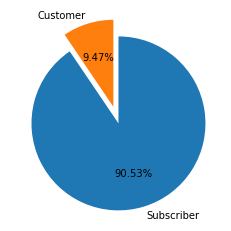

In [236]:
# pie chart
user_category = df_copy['user_type'].value_counts()
plt.pie(user_category, explode = (.1, .1), labels = user_category.index,
        startangle = 90, counterclock = False, autopct = '%1.2f%%');
print(user_category.to_string())

> Most users are actually subscribers (90.5% of total users) who are using the program more than actual customers who represents only 9.5% of total users.

#### Daily Ride Usage

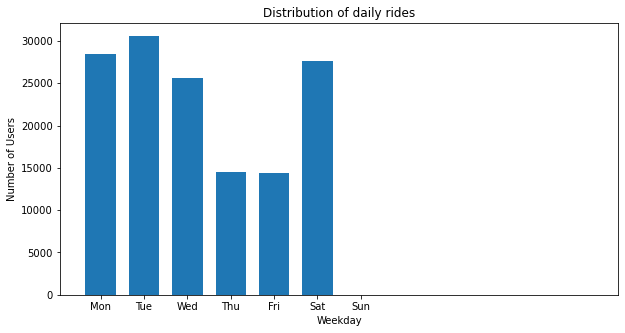

In [254]:
# label to use into plot
Weekday_labels = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

# a histogram with gaps between bars
bin_edges = np.arange(.5, 13.5 , 1)
plt.figure(figsize=[10, 5])
plt.hist(data = df_copy, x = 'start_weekday', bins = bin_edges, rwidth = .7)
plt.xticks(np.arange(1, 8, 1), Weekday_labels)
plt.title('Distribution of daily rides')
plt.xlabel('Weekday')
plt.ylabel('Number of Users');

> The ride usage is most used on Tuesday with over 30,000. The usage decreases significantly on the weekends and no activity on Sunday.

#### Distribution of start hour

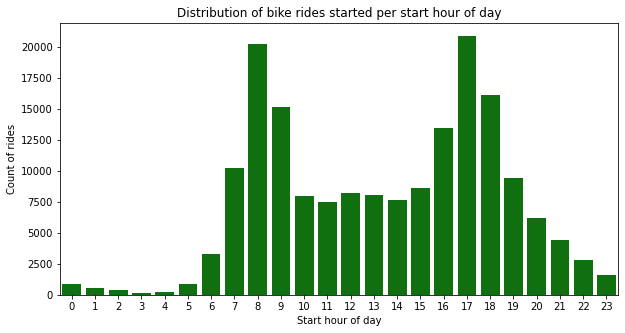

In [262]:
# a distribution of start hour
plt.figure(figsize = (10, 5))
sb.countplot(data = df_copy, x = 'start_hour', color='g')
plt.title('Distribution of bike rides started per start hour of day')
plt.xlabel('Start hour of day')
plt.ylabel('Count of rides');

> The most busy hour is 5 PM, second busy hour is 8 AM. The busy hours are 7-9 AM in morning and 4-6 PM in the evening. This time is common commuting time.

#### Gender Distribution

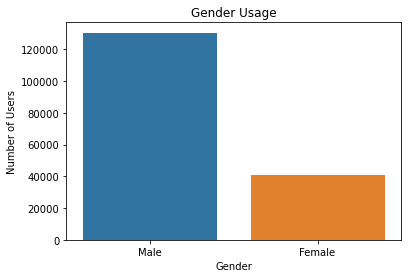

In [277]:
# barplot of gender usage
sb.countplot(data = df_copy.loc[df_copy['member_gender'] != 'Other'],
             x = 'member_gender')
plt.title('Gender Usage')
plt.xlabel('Gender')
plt.ylabel('Number of Users');

> Males use the bike service overwhelmily more than females,
Over 120,000 for males.

#### Age Distribution

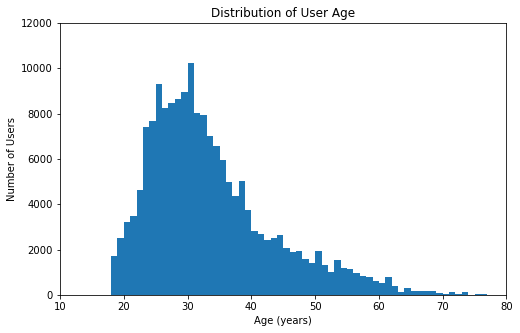

In [290]:
# age distribution.
bins = np.arange(0, df_copy['member_birth_year'].astype(float).max() + 1, 1)
plt.figure(figsize = [8, 5])
plt.hist(data = df_copy, x = 'member_birth_year', bins = bins)
plt.axis([1939, 2009, 0, 12000])
plt.xticks([1939, 1949, 1959, 1969, 1979, 1989, 1999, 2009], [(2019-1939), (2019-1949), (2019-1959), (2019-1969), (2019-1979), (2019-1989), (2019-1999), (2019-2009)])
plt.gca().invert_xaxis()
plt.title('Distribution of User Age')
plt.xlabel('Age (years)')
plt.ylabel('Number of Users');

> Most users are between the age 25 and 35.

#### Top 10 start station name

In [325]:
# Finding top 10 start station name
start_station = df_copy.groupby('start_station_name').agg(
    {'start_station_name': 'count'}).rename(
    columns={'start_station_name': 'counts'}).reset_index().sort_values(
    'counts', ascending=False).head(10).sort_values('counts')

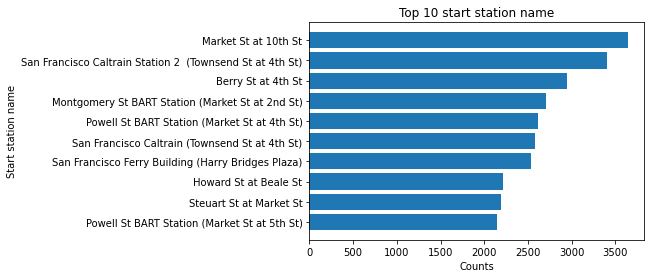

In [327]:
# bar plot for top 10 start station name
plt.barh(start_station['start_station_name'], start_station['counts'])
plt.title('Top 10 start station name')
plt.ylabel('Start station name')
plt.xlabel('Counts');

> As we see here the top 10 start station name and the most start staion is Market St at 10th St, San Francisco Caltrain Station 2

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> The bike duration variable took on a large range of values. I did have to perform a log transform. The data looked bimodal under the log transformation with one peak between 8 and 10 minutes.

> The birth year shows that the user age is between 25 and 35 accounts for the largest proportion.

> Tuesday and Monday shows the steep jump in usage.

> The number of subscribers are much more than that of customers, while the number of males are much more than that of female and other.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> We converted several variables to a correct datatype (start_time, end_time, bike_share_for_all_trip). And created several additional variables (start_weekday, start_hour, duration_min) to be able to create plots with different time resolutions.


## Bivariate Exploration

> To start off with, I want to look at the pairwise correlations present between features in the data.

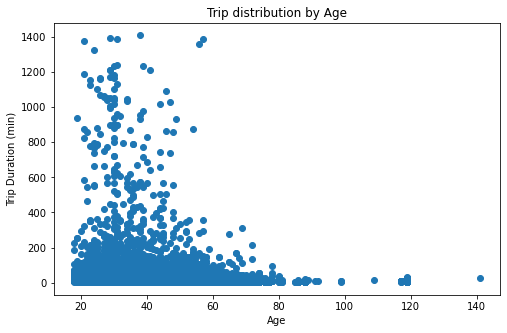

In [337]:
# Add new column for age
df_copy['age'] = (2019 - df_copy.member_birth_year)

# Scatter plot showing distribution between age and trip duration
plt.figure(figsize = [8, 5])
plt.scatter(data = df_copy, x = 'age', y = 'duration_min')
plt.title('Trip distribution by Age')
plt.xlabel('Age')
plt.ylabel('Trip Duration (min)');

> The concentration of rides are for persons between ages 25 and 45 showing the inverse relationship between age and the trip duration.

#### Trip Duration and Gender

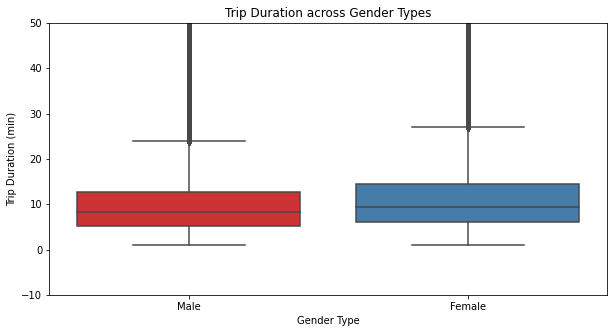

In [349]:
# A box plot showing comparisons between quatitative and categorical variables
plt.figure(figsize = [10, 5])
sb.boxplot(data = df_copy.loc[df_copy['member_gender'] != 'Other'],
           x = 'member_gender', y = 'duration_min', palette='Set1')
plt.ylim(-10, 50)
plt.title('Trip Duration across Gender Types')
plt.xlabel('Gender Type')
plt.ylabel('Trip Duration (min)');

> The boxplot shows that females have a higher trip duration than males.

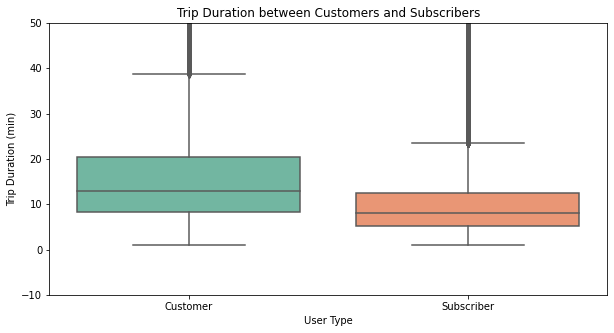

In [350]:
# A box plot showing comparisons between quatitative and categorical variables
plt.figure(figsize = [10, 5])
sb.boxplot(data = df_copy, x = 'user_type', y = 'duration_min', palette='Set2')
plt.ylim(-10, 50)
plt.title('Trip Duration between Customers and Subscribers')
plt.xlabel('User Type')
plt.ylabel('Trip Duration (min)');

> The customer is spending more time on a bike trip than subscribers.

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Trip Duration is very dependendable on the age of the member, suggests that some starting stations are having higher trip durations as starting point and some end stations are having higher trip durations as ending point.


### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> When looking at the relationship between gender members and trip duration I was surprised to find that male had the lowest trip duration.

> I also found that among users, and actual customer is spending more time on a bike trip than subscribers.

## Multivariate Exploration

> Continuing looking at the same variables I want to explore the relationship between age, gender and the trip durations

#### Duration Vs Genders

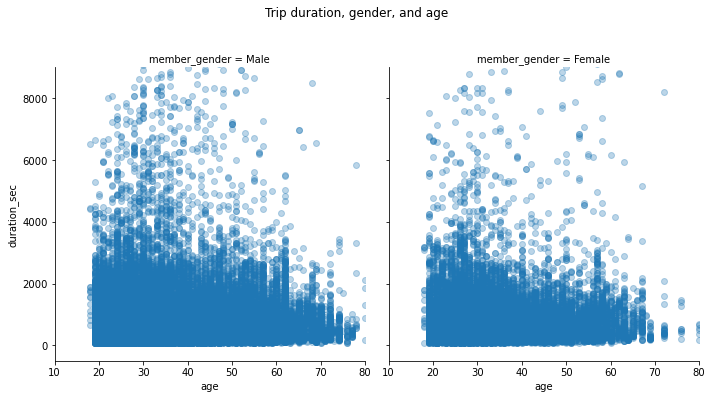

In [368]:
gender = sb.FacetGrid(data = df_copy.loc[df_copy['member_gender'] != 'Other'],
                     col_wrap = 2, height = 5, col = 'member_gender',
                      xlim = [10, 80], ylim = [-500, 9000])
gender.map(plt.scatter, 'age', 'duration_sec', alpha = .3)
gender.fig.suptitle('Trip duration, gender, and age', y = 1.1);

> Comparing the gender types as it relates to trip duration, the age 20 to 40 represents the group that does most of the rides. Females and males do appear to have similar ride average.

#### Duration Vs User Type

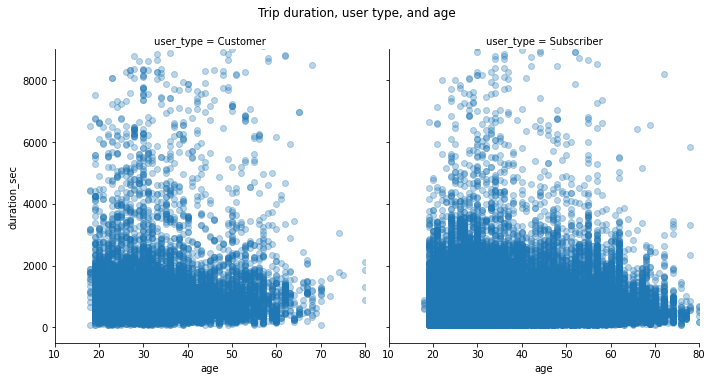

In [369]:
user_type = sb.FacetGrid(data = df_copy, col = 'user_type', col_wrap = 2, 
                        height = 5, xlim = [10, 80], ylim = [-500, 9000])
user_type.map(plt.scatter, 'age', 'duration_sec', alpha = .3)
user_type.fig.suptitle('Trip duration, user type, and age', y=1.05);

> For the age, duration, and gender, for the others leap at an older age (around 60 years) to got 3000 trip duration.

> For the age, duration, and user type, both Customer and Subscriber are showing similar trends for age and trip duration, but for subscribers the trip duration is higher for older age.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> I observed that although the number of users for male is higher but percentage is higher for women and other in trip duration. And,for the others leap at an older age (around 60 years) to got 3000 trip duration which is a peak. Also, for subscribers the trip duration is higher than customer for older age.

### Were there any interesting or surprising interactions between features?

> Looking back on the plots, leaping for other gender at an older is a surprise. And, for subscribers the trip duration is higher than customer for older age is a surprise.

In [373]:
party_attendees = ['Adela', 'Fleda', 'Owen', 'May', 'Mona', 'Gilbert', 'Ford']
round(len(party_attendees) / 2)

4

In [374]:
party_attendees[round(len(party_attendees) / 2): -1]

['Mona', 'Gilbert']

In [378]:
def fashionably_late(arrivals, name):
    """Given an ordered list of arrivals to the party and a name, return whether the guest with that
    name was fashionably late.
    """
    return True if name in arrivals[round(len(arrivals) / 2): -1] else False

In [381]:
fashionably_late(party_attendees, 'May')

False